In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

In [2]:
'''Where to save the neural network'''
PATH = './NNKLD.pth'
device = torch.device("cpu")
'''Avoid bugs in tqdm'''
try:
    tqdm._instances.clear()
except:
    pass

In [3]:
#Data import and cleaning:
df = pd.read_csv('Data/Train.csv')
df.head()

,P,T,DenL,DenG,VisL,ST,ID,Ang,Vsl,Vsg,Flow Pattern.1
0,-0.196738,-0.057888,-0.868440,0.034532,1.876533,-0.131231,0.166563,-0.007434,0.060833,-0.527684,4
1,-0.186723,0.058889,0.454672,-0.286353,-0.559156,-0.129272,-0.810783,-0.761293,-0.594887,0.275044,2
2,-0.184784,0.058889,0.454672,-0.286353,-0.559156,-0.129272,-0.810783,1.751570,1.229230,-0.663527,0
3,-0.188015,0.058889,0.454672,-0.286353,-0.559156,-0.129272,0.159103,0.495138,2.214211,-0.665079,0
4,-0.187046,0.058889,0.454672,-0.286353,-0.559156,-0.129272,0.159103,-0.761293,2.357033,-0.424027,0


In [4]:
df

,P,T,DenL,DenG,VisL,ST,ID,Ang,Vsl,Vsg,Flow Pattern.1
0,-0.196738,-0.057888,-0.868440,0.034532,1.876533,-0.131231,0.166563,-0.007434,0.060833,-0.527684,4
1,-0.186723,0.058889,0.454672,-0.286353,-0.559156,-0.129272,-0.810783,-0.761293,-0.594887,0.275044,2
2,-0.184784,0.058889,0.454672,-0.286353,-0.559156,-0.129272,-0.810783,1.751570,1.229230,-0.663527,0
3,-0.188015,0.058889,0.454672,-0.286353,-0.559156,-0.129272,0.159103,0.495138,2.214211,-0.665079,0
4,-0.187046,0.058889,0.454672,-0.286353,-0.559156,-0.129272,0.159103,-0.761293,2.357033,-0.424027,0
...,...,...,...,...,...,...,...,...,...,...,...
4567,-0.189630,0.058889,0.454672,-0.286353,-0.559156,-0.129272,-0.810783,0.369495,-0.599027,0.941907,2
4568,-0.185107,0.058889,0.454672,-0.286353,-0.559156,-0.129272,0.159103,1.248997,-0.480698,-0.663478,4
4569,-0.196738,-0.057888,-0.868440,0.034532,1.876533,-0.131231,-0.780941,0.118209,-0.149095,2.107323,3
4570,-0.187046,0.058889,0.454672,-0.286353,-0.559156,-0.129272,-0.810783,-0.258720,-0.572331,0.305115,2


In [5]:
X = np.array(df.iloc[:,:-1])
Y = np.array(df.iloc[:,-1])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#We convert them into tensors:
y_test = torch.Tensor(np.eye(5)[[i for i in y_test]])
y_train = torch.Tensor(np.eye(5)[[i for i in y_train]])
X_train = torch.Tensor(X_train).float()
X_test = torch.Tensor(X_test).float()

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #Input = Multiphase flow properties Output =  neurons
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 5)
    
    def forward(self, x):
        #Activation function in F.relu (rectified linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc4(x)
        
        return F.log_softmax(x, dim=1, )

In [8]:
net = Net().to(device)
try:
    checkpoint = torch.load(PATH, map_location='cpu')
    net.load_state_dict(checkpoint['net_state_dict'])
    net.eval()
    EPO_tot = checkpoint['epoch']
    loops = checkpoint['hist']
    print("Loading Existing Network")
except Exception:
    EPO_tot = 0
    loops = 0
    print("Creating New Network")
    pass 

Loading Existing Network


In [9]:
#Optimizer and loss function:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.KLDivLoss()

In [10]:
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

In [11]:
def test(size=100):
    
    random_start = np.random.randint(len(X_test)-size)
    X, y = X_test[random_start:random_start+size], y_test[random_start:random_start+size]
    val_acc, val_loss = fwd_pass(X.to(device), y.to(device))

    return val_acc, val_loss    
        
val_acc, val_loss = test()
print(val_acc, val_loss)

0.94 tensor(0.0396, grad_fn=<KlDivBackward>)


C:\Users\benet\Anaconda3\envs\Phoenix1-8\lib\site-packages\torch\nn\functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


In [12]:
MODEL_NAME = f"model-{int(time.time())}"

def train(BATCH_SIZE = 64*3, EPOCHS = 100, metric = loops):
    with open('model.log', 'a') as f:
        for epoch in tqdm(range(EPOCHS)):
            ep = EPO_tot+epoch+1
            for i in range(0, len(X_train), BATCH_SIZE):
                batch_X = X_train[i:i+BATCH_SIZE].to(device)
                batch_y = y_train[i:i+BATCH_SIZE].to(device)
                
                metric +=1
                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                if i % 50 == 0:
                    val_acc, val_loss = test(size=BATCH_SIZE*2)
                    f.write(f"{MODEL_NAME}, {metric}, {round(float(acc), 2)}, {round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)},{ep}\n")
        torch.save({'epoch': ep,'net_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss, 'hist':metric}, PATH)

In [13]:
train(EPOCHS=500)

100%|██████████| 500/500 [02:40<00:00,  3.11it/s]


In [14]:
test()

(0.9, tensor(0.0443, grad_fn=<KlDivBackward>))

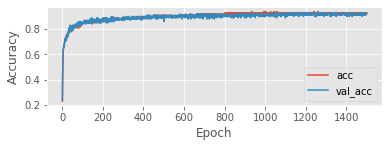

In [15]:
style.use('ggplot')
model_name = 'model'

def create_acc_loss_graph(model_name):
    contents = open('model.log', 'r').read().split('\n')
    
    times = []
    accuracies = []
    losses = []
    
    val_accs = []
    val_losses = []
    epochs = []
    
    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(',')
            
            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))
            epochs.append(float(epoch))
            
     
    fig = plt.figure()
    
    ax1 = plt.subplot2grid((2, 1), (0, 0))
    #ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)
    
    

    ax1.plot(epochs, accuracies, label='acc')
    ax1.plot(epochs, val_accs, label='val_acc')
    ax1.legend(loc=4)
    
    #ax2.plot(epochs, losses, label='loss')
    #ax2.plot(epochs, val_losses, label='val_loss')
    #ax2.legend(loc=1)
    
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    
    plt.show()
    
    
    return epochs, val_accs, accuracies
    
epochs, val_accs, accuracies = create_acc_loss_graph(model_name)